In [1]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1899: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'
/home/markus/.local/lib/python3.7/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
credentials = {
  "tenantId": "AnalyticsServiceDev",
  "as_api_host": "https://api-dev.connectedproducts.internetofthings.ibmcloud.com",
  "as_api_key": "a-69xgm4-8bdgtvnsv4",
  "as_api_token": "9X_tMKdupOiJ!mzaPV",
  "config" : {
      "objectStorageEndpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net",
      "bos_runtime_bucket" : "analytics-runtime-analyticsservicedev-799d2008b460",
      "bos_logs_bucket" : "analytics-logs-analyticsservicedev-32703c52ec8b"
  },
  "objectStorage": {
      "username" : "58ddd86b5de8468b819d385046f17033",
      "password" : "ee0d6c5521ce9ff100f91b0e37d4eb8cc1a038b5a6d05b38",
      "region" : "us",
      "endpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net"
  },
  "db2": {
    "username": "bluadmin",
    "password": "ZmM5MmE5NmZkZGZl",
    "databaseName": "BLUDB",
    "port": 50000,
    "httpsUrl": "https://dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000",
    "host": "dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net"
  }
}
EngineLogging.configure_console_logging(logging.DEBUG)

2019-10-07T12:27:42.789 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [3]:
db_schema = None
db = Database(credentials=credentials)
print (db)

2019-10-07T12:27:45.629 DEBUG iotfunctions.db.__init__ Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2019-10-07T12:27:45.630 INFO iotfunctions.db.__init__ Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:ZmM5MmE5NmZkZGZl@dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000/BLUDB;
2019-10-07T12:27:45.630 DEBUG iotfunctions.db.__init__ created a CosClient object
2019-10-07T12:27:48.421 DEBUG iotfunctions.db.__init__ Db connection established
2019-10-07T12:27:48.423 DEBUG urllib3.connectionpool._new_conn Starting new HTTPS connection (1): api-dev.connectedproducts.internetofthings.ibmcloud.com


/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


2019-10-07T12:27:53.744 DEBUG urllib3.connectionpool._make_request https://api-dev.connectedproducts.internetofthings.ibmcloud.com:443 "GET /api/meta/v1/AnalyticsServiceDev/entityType HTTP/1.1" 200 None
2019-10-07T12:27:54.274 DEBUG iotfunctions.db.http_request http request successful. status 200


In [126]:
# Get stuff in
df_input = pd.read_csv('./anomalyoutput.csv',
                  parse_dates=['timestamp_date','metricTS_date'])

# and sort it by timestamp
df_input = df_input.sort_values(by='timestamp')

df_input.head(18)


,groupdId,edgeNodeId,timestamp,seq,metricName,metricTS,dataType,Val,timestamp_date,metricTS_date,...,DELTA,$O-Anomaly,$O-AnomalyIndex,$O-PeerGroup,$O-Field-1,$O-FieldImpact-1,$O-Field-2,$O-FieldImpact-2,$O-Field-3,$O-FieldImpact-3
625,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736281080,Float,62.385025,2019-06-28 15:38:22,2019-06-28 15:38:01,...,0.003498,F,0.730439,1,Val,0.589966,DELTA,0.235653,SDEV,0.174381
1266,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736296085,Float,62.378570,2019-06-28 15:38:22,2019-06-28 15:38:16,...,0.006455,F,0.648318,1,Val,0.674136,DELTA,0.190081,SDEV,0.135783
717,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736291083,Float,62.383545,2019-06-28 15:38:22,2019-06-28 15:38:11,...,0.004299,F,0.707579,1,Val,0.611002,DELTA,0.223293,SDEV,0.165704
1732,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736301086,Float,62.369650,2019-06-28 15:38:22,2019-06-28 15:38:21,...,0.014753,F,0.500322,1,Val,0.890645,DELTA,0.067947,SDEV,0.041407
653,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736286082,Float,62.384403,2019-06-28 15:38:22,2019-06-28 15:38:06,...,0.003441,F,0.726233,1,Val,0.594191,DELTA,0.238437,SDEV,0.167371
1724,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736266076,Float,62.388523,2019-06-28 15:38:22,2019-06-28 15:37:46,...,0.013050,F,0.503703,1,Val,0.848997,DELTA,0.092395,SDEV,0.058608
1707,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736276079,Float,62.387844,2019-06-28 15:38:22,2019-06-28 15:37:56,...,0.012463,F,0.509544,1,Val,0.840516,DELTA,0.101177,SDEV,0.058307
394,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736246070,Float,62.401840,2019-06-28 15:38:22,2019-06-28 15:37:26,...,0.000000,F,0.835092,1,Val,0.497273,DELTA,0.289276,SDEV,0.213451
463,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736261074,Float,62.399895,2019-06-28 15:38:22,2019-06-28 15:37:41,...,0.001987,F,0.759394,1,Val,0.549201,DELTA,0.264137,SDEV,0.186662
468,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736256073,Float,62.401573,2019-06-28 15:38:22,2019-06-28 15:37:36,...,0.001987,F,0.757375,1,Val,0.548624,DELTA,0.264841,SDEV,0.186534


In [9]:
# start with a single sensor
df_temp = df_input[['timestamp','Val']]

# turn timestamp into the index
df_temp = df_temp.set_index('timestamp')

# fill out the time gaps by backward filling - 2nd order splines are overkill I guess
#upsampled = df_temp.resample('5min').bfill()
#df_temp = upsampled.interpolate(method='spline', order=2)

# we have 963 data points
print (len(df_temp))

2396


Text(0, 0.5, 'Val - Temperature')

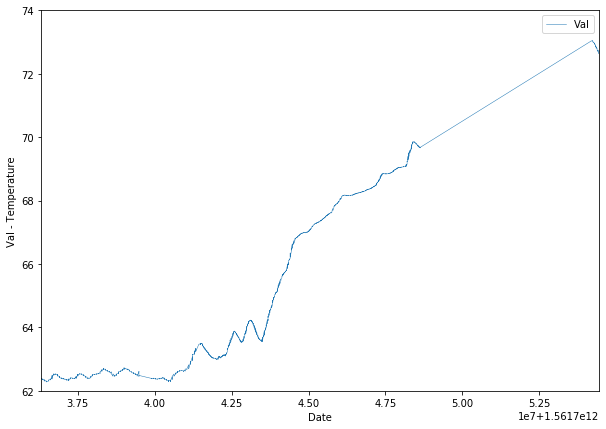

In [29]:
#df_temp = df_input[(df_input.DEVICEID == 'A101')]
#tmin = df_temp.head(1).EVT_TIMESTAMP.astype(np.int64)
#tmax = df_temp.tail(1).EVT_TIMESTAMP.astype(np.int64)
#tdiff = np.subtract(tmax, tmin) // 300000000000  # from nanosec to 5 min steps


fig, ax = plt.subplots(1, 1, figsize=(10,7))
df_temp.plot(ax=ax, lw=.5, y='Val')
ax.set_ylim(62, 74)
ax.set_xlabel('Date')
ax.set_ylabel('Val - Temperature')

In [36]:
# Fourier transform
temp_fft = sp.fftpack.fft(df_temp[['Val']])
# Spectral density (energy per frequency)
temp_psd = np.abs(temp_fft) ** 2
# return sample frequencies - roughly every 5 mins
frame_rate = 1 / 200  # Hz = fft_freq * frame_rate
fftfreq = sp.fftpack.fftfreq(len(temp_psd), frame_rate)
i = fftfreq > 0

Text(0, 0.5, 'PSD (dB)')

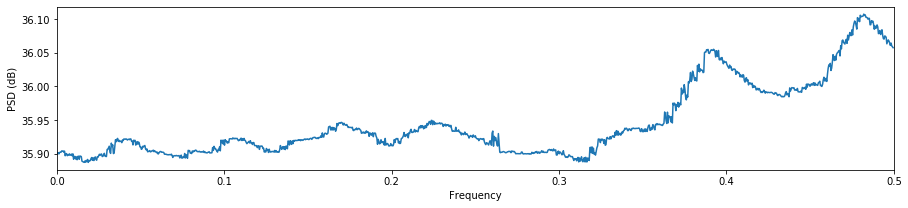

In [46]:
# Interpreting the frequency domains over the full period doesn't do the trick
fig, ax = plt.subplots(1, 1, figsize=(15,3))
ax.plot(fftfreq[i] * frame_rate, 10 * np.log10(temp_psd[i]))
#ax.plot(fftfreq[i] * frame_rate, temp_psd[i])
ax.set_xlim(0, 0.5)
#ax.set_ylim(0, 101)
ax.set_xlabel('Frequency')
ax.set_ylabel('PSD (dB)')


In [78]:
# so apply windowing first - chopping the time series into overlapping 6h windows (with ~72 datapoints)
M = 24
df_temp['timestamp'] = df_temp.index
temperature = df_temp[['Val']].to_numpy().reshape(-1,)

#print (temperature.shape, M)
slices = skiutil.view_as_windows(temperature, window_shape=(M,))
slices.shape

hann = np.hanning(M + 1)[:-1]
slices = slices * hann
slices = slices.T
slices.shape

(24, 2373)

In [79]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

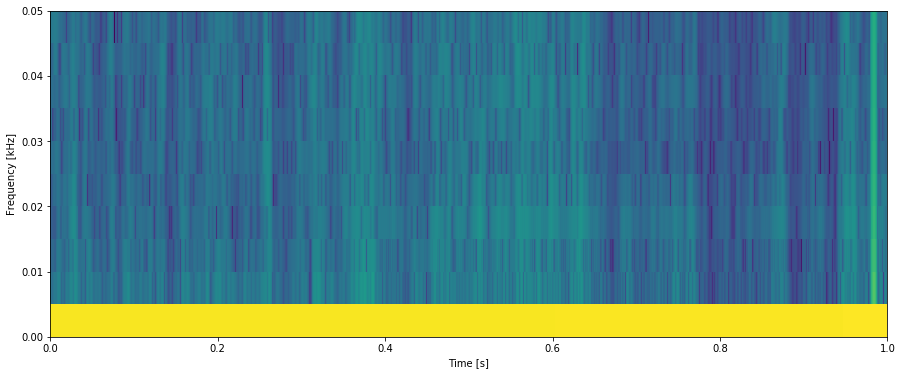

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

S = 20 * np.log10(spectrum / np.max(spectrum))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, 1, 0, 100 / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');


2019-10-07T13:43:17.651 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


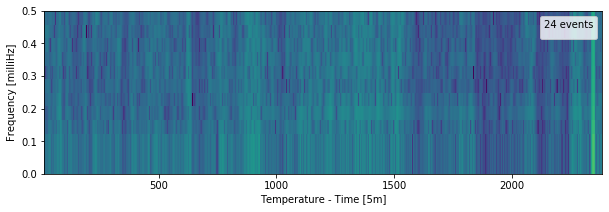

In [81]:
# this is a bit easier
from scipy import signal

rate = 1
MS = 24 # 2hours
freqsTS, timesTS, SxTS = signal.spectrogram(temperature, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - MS/12,
                                      detrend=False, scaling='spectrum')
# cut off frequencies too low to fit into the window the window

freqsTSb = (freqsTS > 2/MS).astype(int)

freqsTS = freqsTS * freqsTSb

#EPS = np.dot(SxPS.T, freqsPS)
#EPS = np.log10(np.dot(SxPS.T, freqsPS))
ETS = np.log10(np.dot(SxTS.T, freqsTS))

f, ax = plt.subplots(1,1,figsize=(10,3))

ax.pcolormesh(timesTS, freqsTS, 10 * np.log10(SxTS)) #, cmap='coolwarm')
ax.set_ylabel('Frequency [milliHz]')
ax.set_xlabel('Temperature - Time [5m]')
ax.legend(title='24 events')


In [82]:
# compute zscore over the energy
ets_zscore = (ETS - ETS.mean())/ETS.std(ddof=0)

# absolute zscore > 3 ---> anomaly
ets_zscoreb = abs((ets_zscore > 3).astype(float) + (ets_zscore < -3).astype(float))

# make matplotlib not plot the zeroes
ets_zscoreb[ets_zscoreb == 0] = 'nan'
ets_zscore.shape

(1187,)

Text(0, 0.5, 'Temperature - Energy')

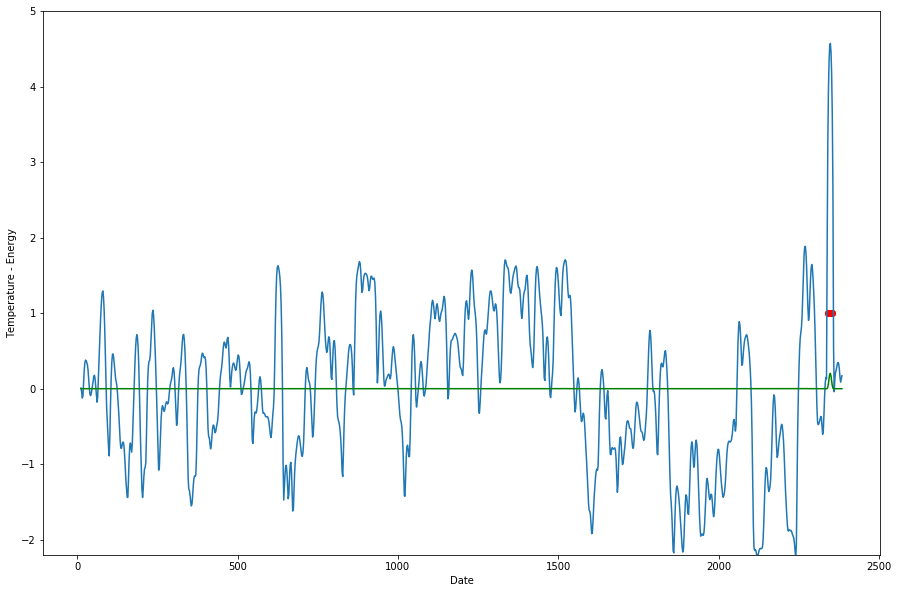

In [118]:

ETS = np.log10(np.dot(SxTS.T, freqsTS))
ETS = np.dot(SxTS.T, freqsTS)


f, ax = plt.subplots(1,1,figsize=(15,10))

ax.plot(timesTS, ets_zscore)
ax.plot(timesTS, ETS, color = 'green')
ax.set_ylim(-2.2, 5)
#ax.set_xlim(0, 930)
ax.scatter(timesTS, ets_zscoreb, color = 'red')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature - Energy')

Text(0, 0.5, 'D Temperature')

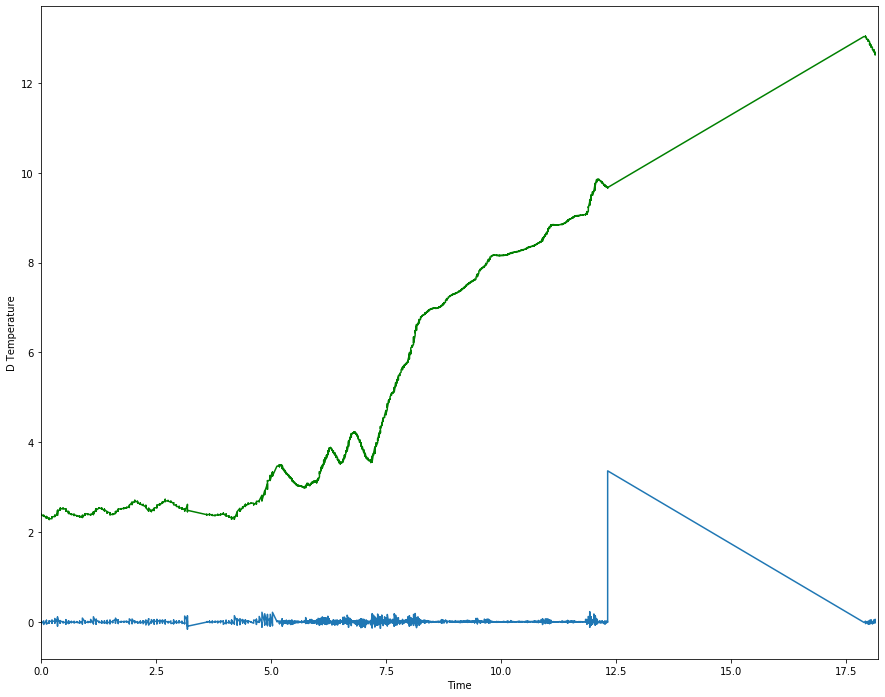

In [130]:
# look at the first discrete derivate (time)
temp_dvt = np.append(np.diff(df_temp['Val']),0)
temp_t = df_temp['Val'].values
temp_dt = (df_temp.index.values.astype(np.int64) - 1561736302064 )/ 1000000

fig, ax = plt.subplots(1, 1, figsize=(15,12))

ax.plot(temp_dt, temp_dvt)
ax.plot(temp_dt, temp_t - 60, color='green')
ax.set_xlim(0, 18.2)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')

In [123]:
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
#knn = KNN()
cblof = CBLOF(n_clusters=30, n_jobs=-1)
#pred = knn.fit_predict(temp_dvt.reshape(-1,1))
cblof.fit(temp_t.reshape(-1,1))
pred = cblof.predict(temp_t.reshape(-1,1))


In [124]:
l_dvt = temp_t * pred
l_dvt[l_dvt == 0] = 'nan'

Text(0, 0.5, 'D Temperature')

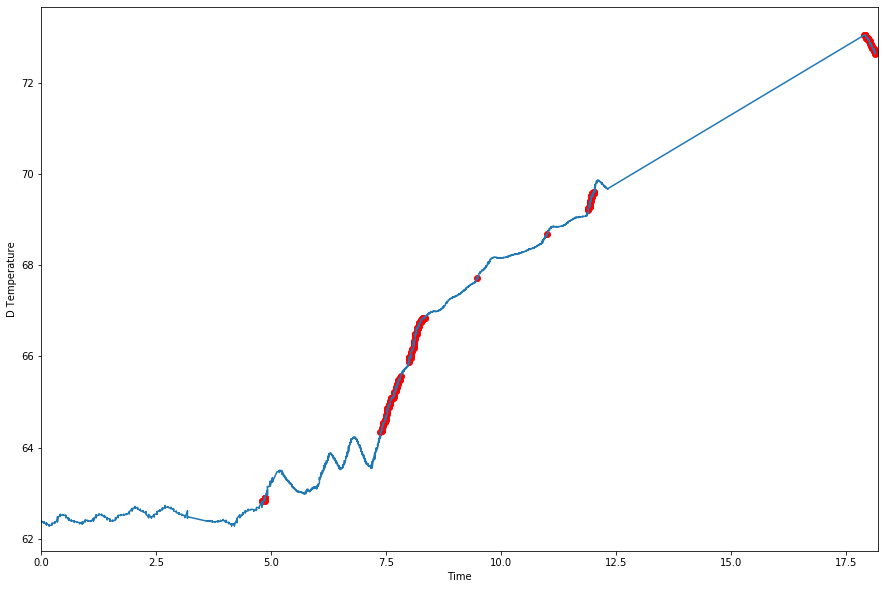

In [128]:
# KNN is not really suitable it seems, but zscore would definitively do
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.plot(temp_dt, temp_t)
ax.scatter(temp_dt, l_dvt, color = 'red')

ax.set_xlim(0, 18.2)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')
